In [2]:
import librosa
import librosa.display
import os
import pandas as pd
import numpy as np
from time import time 
import random as rd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import threading
from sklearn.metrics import confusion_matrix,accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

path_to_db_voice = "C:\\Users\\antoi\Desktop\\Airbus\\projet_AIRBUS\\db\\voice\\"
path_to_db_plane = "C:\\Users\\antoi\Desktop\\Airbus\\projet_AIRBUS\\db\\plane\\"
path_to_db_both = "C:\\Users\\antoi\Desktop\\Airbus\\projet_AIRBUS\\db\\both\\"

l_voice_records = os.listdir(path_to_db_voice)
l_airplane_records = os.listdir(path_to_db_plane)
l_both_records = os.listdir(path_to_db_both)

In [3]:
def separe_train_test(db_folder_path,n_records,test_size):
    l_records = os.listdir(db_folder_path)
    sub_l_records = rd.sample(l_records,n_records)
    size = len(sub_l_records)
    sep = round(test_size*size)
    sample = rd.sample(sub_l_records,size)
    test = sample[:sep]
    train = sample[sep:]
    return train,test

In [4]:
def gen_X_train_test(db_folder_path,n_records,test_size):
    sp_rec_train = []
    sp_rec_test = []
    hops_train = []
    hops_test = []
    records_train,records_test = separe_train_test(db_folder_path,n_records,test_size)
    i = 0
    for record in records_train:
        print('Building train {}/{}'.format(i,len(records_train)),end='\r')
        signal,sample_rate = librosa.load(db_folder_path + record)
        spectrum = librosa.stft(y=signal,center=False) 
        spectrum = spectrum.astype(float)
        sp_rec_train.append(np.abs(np.transpose(spectrum)))
        hops_train.append(len(signal)//len(spectrum))
        i+=1

        # plt.hist(np.unique(spectrum),bins=200)
        # plt.yscale('log')
        # fig = librosa.display.specshow(spectrum, sr=sample_rate, x_axis='time', y_axis='log')
        # plt.colorbar(format='%+2.0f dB')
        # plt.title('Spectrogram')
        # plt.plot()
        # plt.show()
    i=0
    for record in records_test: 
        print('Building  test {}/{}'.format(i,len(records_test)),end='\r')
        signal,sample_rate = librosa.load(db_folder_path + record)
        spectrum = librosa.stft(y=signal,center=False) 
        spectrum = spectrum.astype(float)
        sp_rec_test.append(np.abs(np.transpose(spectrum)))
        hops_test.append(len(signal)//len(spectrum))
        i+=1

    X_train = np.concatenate(sp_rec_train)
    X_test = np.concatenate(sp_rec_test)

    return X_train,X_test,hops_train,hops_test

In [59]:



n_records = 178

X_voice_train,X_voice_test,hops_voice_train,hops_voice_test= gen_X_train_test(path_to_db_voice,n_records,0.3)
print('Voice done',end='\r')
X_plane_train,X_plane_test,hops_plane_train,hops_plane_test = gen_X_train_test(path_to_db_plane,n_records,0.3)
print('Plane done',end='\r')
X_both_train,X_both_test,hops_both_train,hops_both_test = gen_X_train_test(path_to_db_both,n_records,0.3)
print('Both done',end='\r')

In [6]:
hops_voice_train

[287, 253, 161, 292, 212]

In [60]:
print(len(X_voice_train) + len(X_plane_train) + len(X_both_train))
print(len(X_plane_train[0]))

200951
1025


In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

threshold = 10


import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

y_voice_train = ['Voice' for elt in X_voice_train]
y_plane_train = ['Plane' for elt in X_plane_train]
y_both_train = ['Voice' for elt in X_both_train]

y_voice_test = ['Voice' for elt in X_voice_test]
y_plane_test = ['Plane' for elt in X_plane_test]
y_both_test = ['Voice' for elt in X_both_test]


Y = y_voice_train + y_plane_train + y_both_train + y_plane_test + y_both_test
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

X_train = np.concatenate([X_voice_train,X_plane_train,X_both_train])
X_test = np.concatenate([X_plane_test,X_both_test])

y_train = dummy_y[:len(y_voice_train) + len(y_plane_train) + len(y_both_train)]
y_test = dummy_y[len(y_voice_train) + len(y_plane_train) + len(y_both_train)::]




y_train[0].shape



(2,)

In [66]:
len(y_test)

56221

In [51]:
for k in y_train:
    if k.shape != (2,):
        print(k)


In [67]:
def model():
    model = Sequential()
    model.add(Dense(8, input_dim=1025, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [68]:
model = model()
model.fit(X_train, y_train, epochs=100, batch_size=64)

Epoch 1/100
3140/3140 [==============================] - 3s 856us/step - loss: 0.3872 - accuracy: 0.8182
Epoch 2/100
3140/3140 [==============================] - 3s 862us/step - loss: 0.3272 - accuracy: 0.8462
Epoch 3/100
3140/3140 [==============================] - 3s 845us/step - loss: 0.3153 - accuracy: 0.8521
Epoch 4/100
3140/3140 [==============================] - 3s 846us/step - loss: 0.3100 - accuracy: 0.8542
Epoch 5/100
3140/3140 [==============================] - 3s 864us/step - loss: 0.3064 - accuracy: 0.8556
Epoch 6/100
3140/3140 [==============================] - 3s 856us/step - loss: 0.3039 - accuracy: 0.8573
Epoch 7/100
3140/3140 [==============================] - 3s 851us/step - loss: 0.3015 - accuracy: 0.8578
Epoch 8/100
3140/3140 [==============================] - 3s 872us/step - loss: 0.2993 - accuracy: 0.8590
Epoch 9/100
3140/3140 [==============================] - 3s 854us/step - loss: 0.2987 - accuracy: 0.8595
Epoch 10/100
3140/3140 [==============================]

3140/3140 [==============================] - 3s 863us/step - loss: 0.2775 - accuracy: 0.8713
Epoch 79/100
3140/3140 [==============================] - 3s 875us/step - loss: 0.2769 - accuracy: 0.8714
Epoch 80/100
3140/3140 [==============================] - 3s 870us/step - loss: 0.2770 - accuracy: 0.8717
Epoch 81/100
3140/3140 [==============================] - 3s 869us/step - loss: 0.2773 - accuracy: 0.8721
Epoch 82/100
3140/3140 [==============================] - 3s 857us/step - loss: 0.2764 - accuracy: 0.8720
Epoch 83/100
3140/3140 [==============================] - 3s 828us/step - loss: 0.2764 - accuracy: 0.8719
Epoch 84/100
3140/3140 [==============================] - 3s 832us/step - loss: 0.2767 - accuracy: 0.8723
Epoch 85/100
3140/3140 [==============================] - 3s 841us/step - loss: 0.2762 - accuracy: 0.8720
Epoch 86/100
3140/3140 [==============================] - 3s 836us/step - loss: 0.2761 - accuracy: 0.8722
Epoch 87/100
3140/3140 [==============================] - 3

In [69]:
y_pred = model.predict(X_test)
y_pred_aux = []
for k in y_pred:
    if k[0]>k[1]:
        y_pred_aux.append([1,0])
    else:
        y_pred_aux.append([0,1])

1757/1757 [==============================] - 1s 531us/step


In [70]:
y_pred[0],y_test[0]

(array([0.8360205 , 0.16397953], dtype=float32),
 array([1., 0.], dtype=float32))

In [71]:
from sklearn.metrics import accuracy_score
a = accuracy_score(y_pred_aux,y_test)
print('Accuracy is:', a*100)

Accuracy is: 74.18402376336245


In [ ]:
def has_voice2(x,hop,duration_sec_threshold,error_threshold):
    ratio = np.count_nonzero(x=='Voice')/len(x)
    duration_discrete_threshold = round(duration_sec_threshold * 22050 / hop)
    binary_pred = [0 if elt=='Plane' else 1 for elt in x]
    df_x = pd.DataFrame(binary_pred)
    df_sum = df_x.rolling(duration_discrete_threshold).mean()
    x_plot = [elt*hop/22050 for elt in range(len(x))] #x en seconds
    # plt.plot(x_plot,df_sum[0])
    # plt.show()
    return len(df_sum[df_sum[0]>error_threshold])>0

In [72]:
def has_voice_vote(y,hop,duration_sec_threshold):
    duration_discrete_threshold = round(duration_sec_threshold * 22050 / hop)
    votes = []
    for i in range(len(y)-duration_discrete_threshold):
        #window = y[i:i+duration_discrete_threshold]
        vote_window = 0
        for k in range(i,i+duration_discrete_threshold):
            confiance = y[i][0]-y[i][1]
            vote_window += confiance
        votes.append(vote_window/duration_discrete_threshold)
    return votes
    
                

PARTIE MODELE

In [39]:
# pca = PCA(0.99).fit(X_train)
# X_train = pca.transform(X_train)
# X_test = pca.transform(X_test)
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train,y_train)

RandomForestClassifier(n_jobs=-1)

In [40]:
from sklearn.metrics import accuracy_score

pred = rf.predict(X_test)
accuracy_score(pred,y_test)

0.4558223833257816

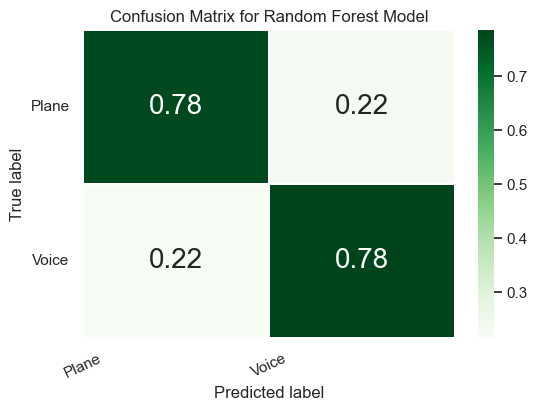

In [145]:


pred = rf.predict(X_test)
matrix = confusion_matrix(pred,y_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(6,4))
sns.set(font_scale=1)
sns.heatmap(matrix, annot=True, annot_kws={'size':20},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Plane','Voice']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

TEST DE LA RF SAUVEGARDEE

In [71]:
import joblib 

rf = joblib.load("random_forest.joblib")
# joblib.dump(rf, "random_forest.joblib")


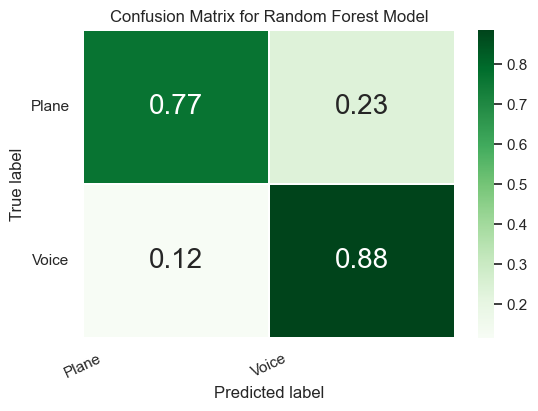

In [78]:
from sklearn.metrics import confusion_matrix,accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns


pred = rf.predict(X_test)
matrix = confusion_matrix(pred,y_test)
# pred = rf.predict(X_test)
# matrix = confusion_matrix(pred,y_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(6,4))
sns.set(font_scale=1)
sns.heatmap(matrix, annot=True, annot_kws={'size':20},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = rf.classes_
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [179]:
def has_voice(x,hop,duration_sec_threshold,error_threshold):
    ratio = np.count_nonzero(x=='Voice')/len(x)
    duration_discrete_threshold = duration_sec_threshold * 22050 / hop
    if len(x) >duration_discrete_threshold and ratio > error_threshold:
        print('Durée de la voix: ',len(x)*hop/22050,'seconds')
        return True
    elif len(x)<duration_discrete_threshold:
        return False
    else:
        half = len(x)//2
        return has_voice(x[:half],hop,duration_sec_threshold,error_threshold) or has_voice(x[half:],hop,duration_sec_threshold,error_threshold)

def has_voice2(x,hop,duration_sec_threshold,error_threshold):
    ratio = np.count_nonzero(x=='Voice')/len(x)
    duration_discrete_threshold = round(duration_sec_threshold * 22050 / hop)
    binary_pred = [0 if elt=='Plane' else 1 for elt in x]
    df_x = pd.DataFrame(binary_pred)
    df_sum = df_x.rolling(duration_discrete_threshold).mean()
    x_plot = [elt*hop/22050 for elt in range(len(x))] #x en seconds
    # plt.plot(x_plot,df_sum[0])
    # plt.show()
    return len(df_sum[df_sum[0]>error_threshold])>0

def gen_valid_test(db_folder_path,n_records):

    l_records = os.listdir(db_folder_path)
    sub_l_records = rd.sample(l_records,n_records)
    sample = rd.sample(sub_l_records,n_records)
    sp_valid = []
    hops_valid = []
    for i in range(n_records):
        print('Building validation set {}/{}'.format(i,n_records),end='\r')
        signal,sample_rate = librosa.load(db_folder_path + sample[i])
        spectrum = librosa.stft(y=signal,center=False) 
        spectrum = spectrum.astype(float)
        # fig = librosa.display.specshow(spectrum, sr=sample_rate, x_axis='time', y_axis='log')
        # plt.colorbar(format='%+2.0f dB')
        # plt.title('Spectrogram')
        # plt.plot()
        # plt.show()
        good_shape_spectrum = np.abs(np.transpose(spectrum))
        sp_valid.append(good_shape_spectrum)
        hops_valid.append(len(signal)//len(good_shape_spectrum))

    return sp_valid,hops_valid

def valid_model(model,duration_threshold,error_threshold,n_records):
    plane_valid,hops_plane = gen_valid_test(path_to_db_plane,n_records)
    both_valid,hops_both = gen_valid_test(path_to_db_both,n_records)

    target_plane = [False for elt in plane_valid]
    target_both = [True for elt in both_valid]
    
    records_valid = plane_valid + both_valid
    target_valid =  target_plane + target_both
    hops_valid = hops_plane + hops_both

    # records_valid = both_valid
    # target_valid =  target_both
    # hops_valid = hops_both

    # records_valid = plane_valid
    # target_valid =  target_plane
    # hops_valid = hops_plane

    # print(hops_valid)

    prediction_for_records = []
    for i  in range(len(records_valid)):
        pred = model.predict(records_valid[i])
        prediction_for_records.append(has_voice2(pred,hops_valid[i],duration_threshold,error_threshold))

    return accuracy_score(target_valid,prediction_for_records)

In [ ]:
valid_model(rf,2,0.63,4)

In [185]:
def hyper_tune_valid(model,n_records,n_iter):
    
    dur_range = np.linspace(1,5,6)
    thresh_range = np.linspace(0.5,1,20)

    best_dur,best_thresh,best_valid = 0,0,0

    for i in range(n_iter):
        
        if best_valid ==1:
            return best_dur,best_thresh,best_valid

        dur = rd.choice(dur_range)
        thresh = rd.choice(thresh_range)
        val = valid_model(model,dur,thresh,n_records)

        if val > best_valid:
            best_valid = val
            best_dur = dur
            best_thresh = thresh

    return best_dur,best_thresh,best_valid



In [186]:
hyper_tune_valid(rf,10,70)

(1.8, 0.7894736842105263, 0.95)